In [1]:
import gym
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
env = gym.make('CarRacing-v0')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1099..1378 -> 279-tiles track


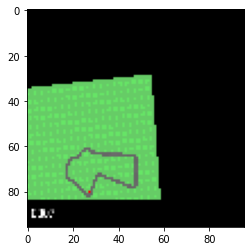

(96, 96, 3)
255 0


In [3]:
obs = env.reset()
plt.imshow(obs)
plt.show()
print(obs.shape)
print(np.max(obs), np.min(obs))

In [4]:
def preprocess(o):
    return cv2.resize(o[:84,:], (64, 64)) / 255.0

In [5]:
# collecting random rollouts for training the VAE
samples = 10_000
ds = np.empty(shape=(samples, 64, 64, 3), dtype=np.float32)
actions = np.empty(shape=(samples, 3), dtype=np.float32)
i = 0
done = False
while i < samples:
    if done:
        obs = env.reset()
        done = False
        ds[i] = preprocess(obs)
        actions[i] = action
        i += 1
    else:
        action = env.action_space.sample()
        obs, r, done, _ = env.step(action)
        ds[i] = preprocess(obs)
        actions[i] = action
        i += 1
print(i)

Track generation: 1199..1503 -> 304-tiles track
Track generation: 1015..1273 -> 258-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1205..1516 -> 311-tiles track
Track generation: 1110..1390 -> 280-tiles track
Track generation: 1175..1473 -> 298-tiles track
Track generation: 981..1233 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1234..1547 -> 313-tiles track
Track generation: 1088..1372 -> 284-tiles track
Track generation: 1100..1379 -> 279-tiles track
10000


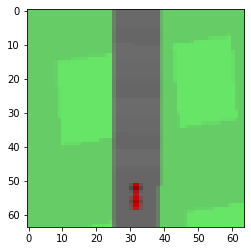

0.8980392 0.0


In [6]:
sample = ds[np.random.choice(len(ds))]
plt.imshow(sample)
plt.show()
print(np.max(sample), np.min(sample))

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [8]:
num_channels = 3
img_width = 64
img_height = 64
input_shape = (img_height, img_width, num_channels)
latent_dim = 32

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=32, kernel_size=4, strides=2, activation='relu')(i)
cx      = Conv2D(filters=64, kernel_size=4, strides=2, activation='relu')(cx)
cx      = Conv2D(filters=128, kernel_size=4, strides=2, activation='relu')(cx)
cx      = Conv2D(filters=256, kernel_size=4, strides=2, activation='relu')(cx)
x       = Flatten()(cx)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)
print(conv_shape)
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])
encoder = Model(i, [mu, sigma, z], name='encoder')

d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = Reshape((1, 1, 1024))(x)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=2, activation='relu')(x)
cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=2, activation='relu')(cx)
cx    = Conv2DTranspose(filters=32, kernel_size=6, strides=2, activation='relu')(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=6, strides=2, activation='sigmoid', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')

vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')

(None, 2, 2, 256)


In [9]:
bce = tf.keras.losses.BinaryCrossentropy()
reconstruction_loss = bce(i, vae_outputs)
reconstruction_loss *= img_width*img_height*num_channels
kl_loss = 1 + sigma - tf.math.square(mu) - tf.math.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=1e-3))

In [10]:
ds = tf.convert_to_tensor(ds, dtype=tf.float32)

In [11]:
vae.fit(ds, ds, epochs=1, batch_size=32)

313/313 [==============================] - 171s 542ms/step - loss: 7845.8262


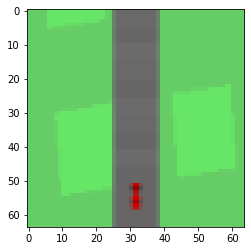

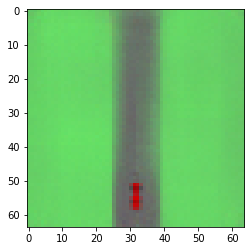

In [12]:
sample = np.array(ds[np.random.choice(len(ds))])
pred = vae.predict(tf.convert_to_tensor([sample]))
plt.imshow(sample.reshape(img_height, img_width, num_channels))
plt.show()
plt.imshow(pred[0].reshape(img_height, img_width, num_channels))
plt.show()

In [13]:
x = ds[:len(ds)-1]
y = ds[1:]
actions = tf.convert_to_tensor(actions[:len(actions)-1], dtype=tf.float32)
ex = encoder.predict(x)[-1]
ey = encoder.predict(y)[-1]

In [14]:
ex = tf.reshape(ex, (-1, 1, latent_dim))
ey = tf.reshape(ex, (-1, 1, latent_dim))
actions = tf.reshape(actions, (-1, 1, 3))

In [30]:
import mdn

output_dims = 32
n_mixtures = 5

hidd = Input(shape=(1, latent_dim))
a = Input(shape=(1, 3))
x = Concatenate(axis=-1)([hidd, a])
x = LSTM(256)(x)
# mixture density network
out = mdn.MDN(output_dims, n_mixtures)(x)

rnn = Model([hidd, a], out)

In [31]:
rnn.compile(loss=mdn.get_mixture_loss_func(output_dims,n_mixtures), optimizer=Adam(lr=3e-4))

In [32]:
rnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1, 32)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1, 3)]       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1, 35)        0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          299008      concatenate_1[0][0]        

In [33]:
rnn.fit([ex, actions], ey, epochs=20, batch_size=32)

Epoch 1/20
313/313 [==============================] - 5s 4ms/step - loss: 41.0327
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 17.5689
Epoch 3/20
313/313 [==============================] - 2s 5ms/step - loss: -17.4363
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: -26.3987
Epoch 5/20
313/313 [==============================] - 1s 5ms/step - loss: -32.3625
Epoch 6/20
313/313 [==============================] - 1s 5ms/step - loss: -36.9889
Epoch 7/20
313/313 [==============================] - 2s 5ms/step - loss: -41.1686
Epoch 8/20
313/313 [==============================] - 2s 5ms/step - loss: -44.0692
Epoch 9/20
313/313 [==============================] - 2s 5ms/step - loss: -46.2080
Epoch 10/20
313/313 [==============================] - 2s 5ms/step - loss: -48.2929
Epoch 11/20
313/313 [==============================] - 2s 6ms/step - loss: -50.3564
Epoch 12/20
313/313 [==============================] - 2s 6ms/step - loss: -51.9837
Epo

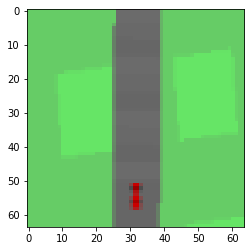

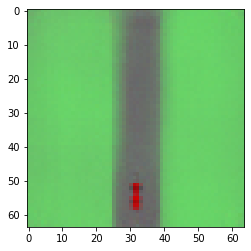

In [35]:
i = np.random.choice(len(ex))
sample = tf.reshape(ex[i], (1, 1, 32))
action = tf.reshape(actions[i], (1, 1, 3))
pred = rnn.predict([sample, action])
y_sample = np.apply_along_axis(mdn.sample_from_output, 1, pred, 32, 5, temp=1.0).reshape(32)
decoded_y_sample = tf.reshape(decoder.predict(tf.convert_to_tensor([y_sample])), (64,64,3))
original = ds[i+1]
plt.imshow(original)
plt.show()
plt.imshow(decoded_y_sample)
plt.show()

Track generation: 1263..1583 -> 320-tiles track


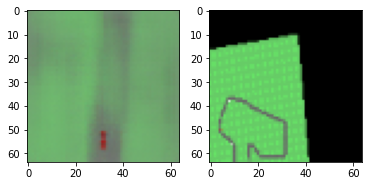

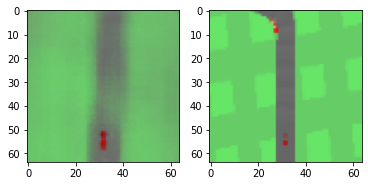

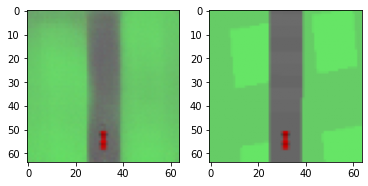

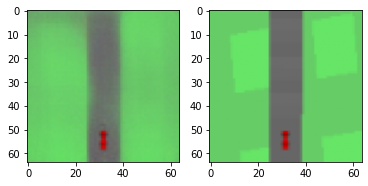

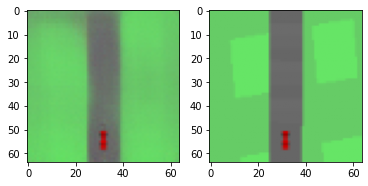

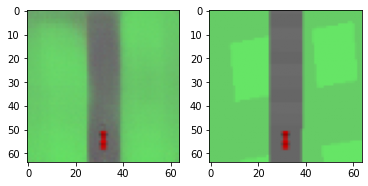

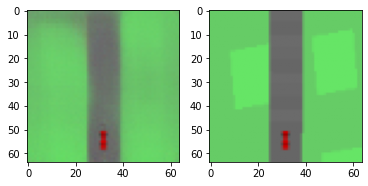

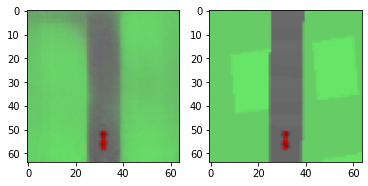

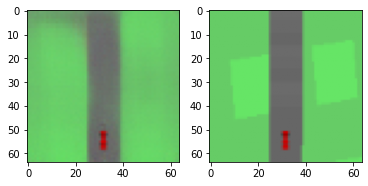

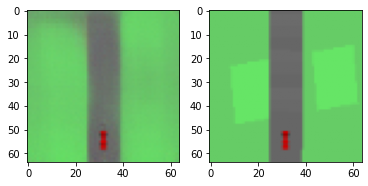

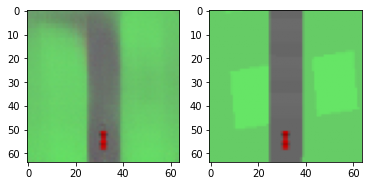

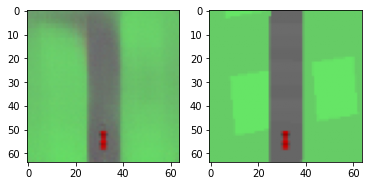

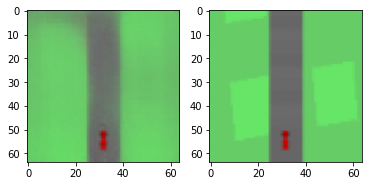

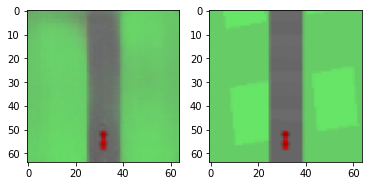

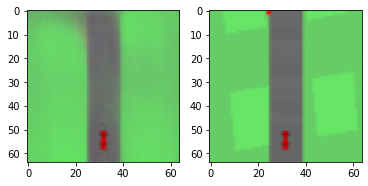

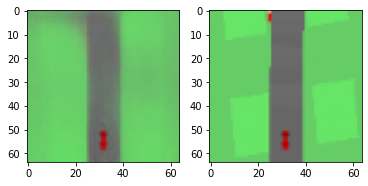

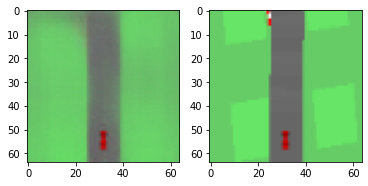

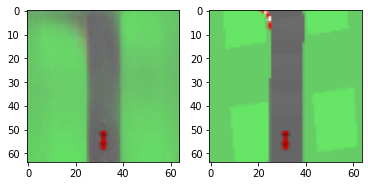

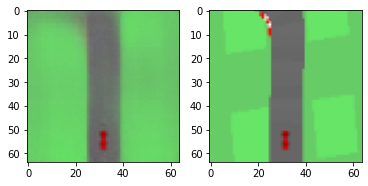

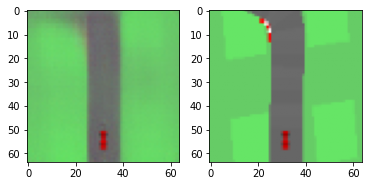

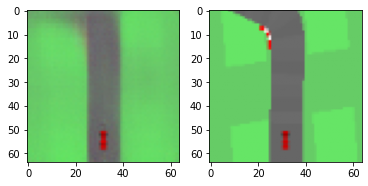

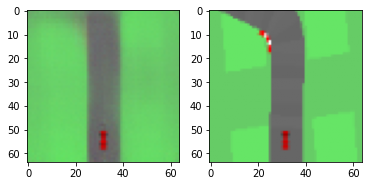

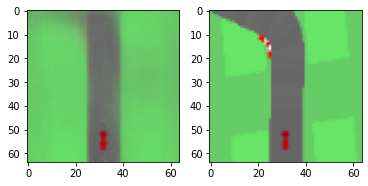

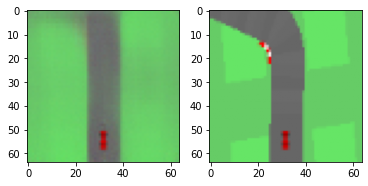

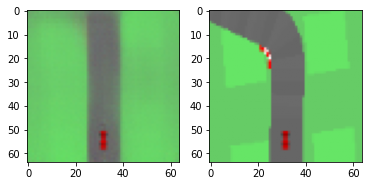

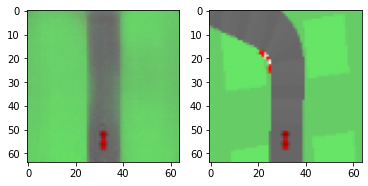

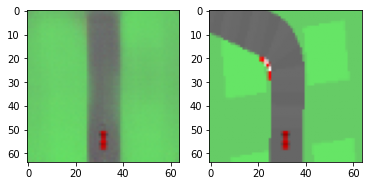

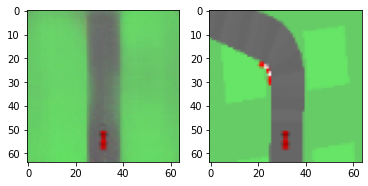

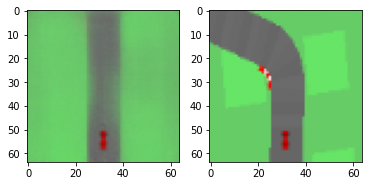

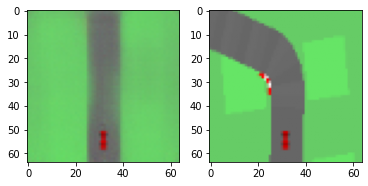

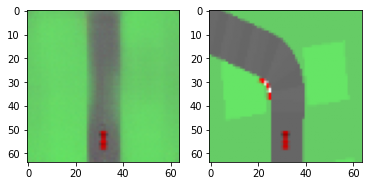

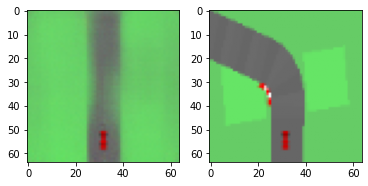

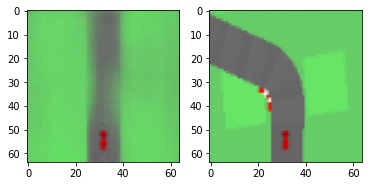

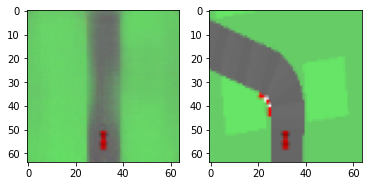

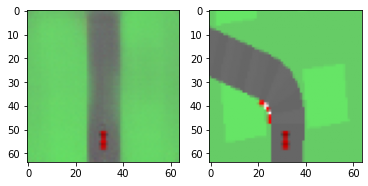

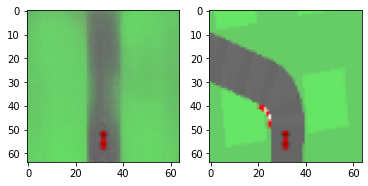

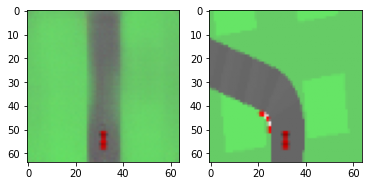

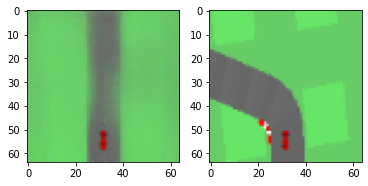

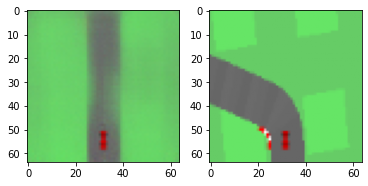

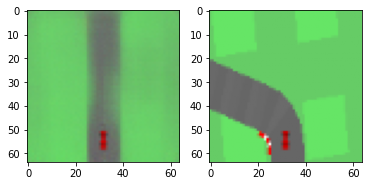

In [38]:
obs = env.reset()
done = False
i = 0
while not done:
    if i == 0:
        o = tf.convert_to_tensor([preprocess(obs)], dtype=tf.float32)
        eo = tf.reshape(encoder.predict([o])[-1], (1, 1, 32))
    action = env.action_space.sample()
    a = tf.reshape(tf.convert_to_tensor([action], dtype=tf.float32), (1, 1, 3))
    pred = rnn.predict([eo, a])
    pred = np.apply_along_axis(mdn.sample_from_output, 1, pred, 32, 5, temp=1.0).reshape(32)
    
    eo = tf.reshape(tf.convert_to_tensor([pred], dtype=tf.float32), (1, 1, 32))
    
    decoded_pred = tf.reshape(decoder.predict(tf.convert_to_tensor([pred])), (64,64,3))
    obs, r, done, _ = env.step(action)
    if i % 25 == 0:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(decoded_pred)
        ax2.imshow(preprocess(obs))
        plt.show()
    i += 1